<a href="https://colab.research.google.com/github/Insomnia2304/PMP-2024/blob/main/Restanta/Ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Subiectul 1

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
from pandas import DataFrame

df = pd.read_csv('date_regresie.csv')

In [ ]:
y = df['Satisfactie'].values.astype(float)
x = []

for col in df.columns[:2]:
  curr = df[col].values.astype(float)
  x_norm = (curr - curr.mean()) / curr.std()
  x.append(x_norm)
x = np.array(x).T
x1 = x[:,0]
x2 = x[:,1]

In [ ]:
# a)
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=y.mean(), sigma=0.01)
    beta1 = pm.Normal('beta1', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=0, sigma=1)
    beta3 = pm.Normal('beta3', mu=0, sigma=1)

    eps_2 = pm.HalfCauchy('eps_2', 5)
    error = pm.Normal('error', sigma = 0.01)

    y_pred = pm.Normal('y_pred', mu=alpha + beta1 * x1 + beta2 * x2 + error, sigma=eps_2, observed=y)

    i_data = pm.sample(1000, tune=1000)

Output()

In [34]:
# b)
az.summary(i_data,var_names=['alpha', 'beta1', 'beta2', 'beta3'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,7.860,0.010,7.841,7.879,0.000,0.000,2615.0,1675.0,1.0
beta1,1.739,0.153,1.460,2.030,0.003,0.002,2457.0,1638.0,1.0
beta2,0.533,0.152,0.246,0.812,0.003,0.002,2961.0,1792.0,1.0
beta3,-0.015,0.979,-1.757,1.837,0.019,0.020,2630.0,1790.0,1.0


c) Observam ca beta1 este cel mai mare, deci putem trage concluzia ca salariul lunar influenteaza cel mai mult satisfactia angajatului. Ceea ce mi se pare si normal in lumea capitalista pe care o traim.

Subiectul 2

In [4]:
df = pd.read_csv('greutati.csv')
df.head()

,Greutate_pește
0,67.21
1,76.13
2,48.32
3,84.90
4,72.24


In [9]:
# a)

k = [3,4,5]
x = df['Greutate_pește'].values

traces = []
models = []

for tags in k:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(tags))
        means = pm.Normal('means',
                          mu=np.linspace(x.min(), x.max(), tags),
                          sigma=10, shape=tags,
                          transform=pm.distributions.transforms.ordered)

        sd = pm.HalfNormal('sd', sigma=10)
        y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=x)

        trace = pm.sample(200, target_accept=0.9, random_seed=69, return_inferencedata=True)
        traces.append(trace)
        models.append(model)

Output()

ERROR:pymc.stats.convergence:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


TypeError: Encountered error in ELPD computation of compare.

   rank    elpd_waic    p_waic  elpd_diff    weight         se       dse  \
4     0  1575.375870  5.310809   0.000000  0.445260  17.723401  0.000000   
5     1  1575.913701  5.922340   0.537830  0.336872  17.781554  0.692323   
3     2  1577.360552  6.141732   1.984681  0.217868  19.202457  2.671202   

   warning     scale  
4     True  deviance  
5     True  deviance  
3     True  deviance  


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

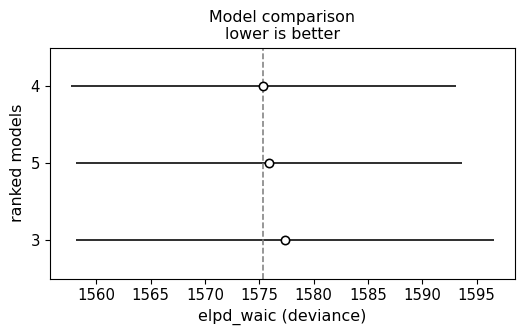

In [18]:
# b)
# [pm.compute_log_likelihood(traces[i], model=models[i]) for i in range(3)]
cmp_df = az.compare(
    dict(zip([str(c) for c in k], traces)),
    method='BB-pseudo-BMA', ic="waic", scale="deviance"
)

print(cmp_df)
az.plot_compare(cmp_df)

# Observam ca 3 subpopulatii reprezinta cel mai bine datele observate

In [20]:
# c)
for i, trace in enumerate(traces):
    means = trace.posterior['means'].values
    mean_means = means.mean(axis=(0, 1))
    print(f"Model {i+1} means: {mean_means}")


Model 1 means: [44.3363188  66.12987136 81.14571242]
Model 2 means: [42.86252323 57.80166428 70.89643864 90.51411031]
Model 3 means: [42.36190791 51.68156863 65.41506861 72.90038624 90.37377685]
